In [10]:
import os
import cv2
import numpy as np
import math
import glob
import matplotlib.pyplot as plt

from IPython.display import Image

%matplotlib inline

DATA_RAW_PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../data/raw"))
DATA_OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/output"))

# To get the example images that below worked on please first run the download_assets.py file

#### Align an image to a template.
![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_image-alignment-using-opencv.jpg "Image Alignment")

#### Theory

1. A **Homography** transforms a square to arbitrary quad. 

![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_motion-models.jpg "Motion Models")

#### Theory

2. Images of two planes are related by a **Homography**
3. We need **4 corresponding points** to estimate Homography


!["Homography Example"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_homography-example.jpg)

#### Step 1: Read Tempalate and Scanned Image

In [11]:
# Read reference image
ref_path = f"{DATA_RAW_PATH}/form.jpg"
print("Reading reference image:", ref_path)
img_ref_bgr = cv2.imread(ref_path, cv2.IMREAD_COLOR)
img_ref_rgb = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2RGB)

# Read image to be aligned
img_path = f"{DATA_RAW_PATH}/scanned-form.jpg"
print("Reading image to align:", img_path)
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

Reading reference image: /Users/merteldem1r/Documents/OpenCV-Bootcamp/7-Image-Features-and-Alignment/data/raw/form.jpg
Reading image to align: /Users/merteldem1r/Documents/OpenCV-Bootcamp/7-Image-Features-and-Alignment/data/raw/scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

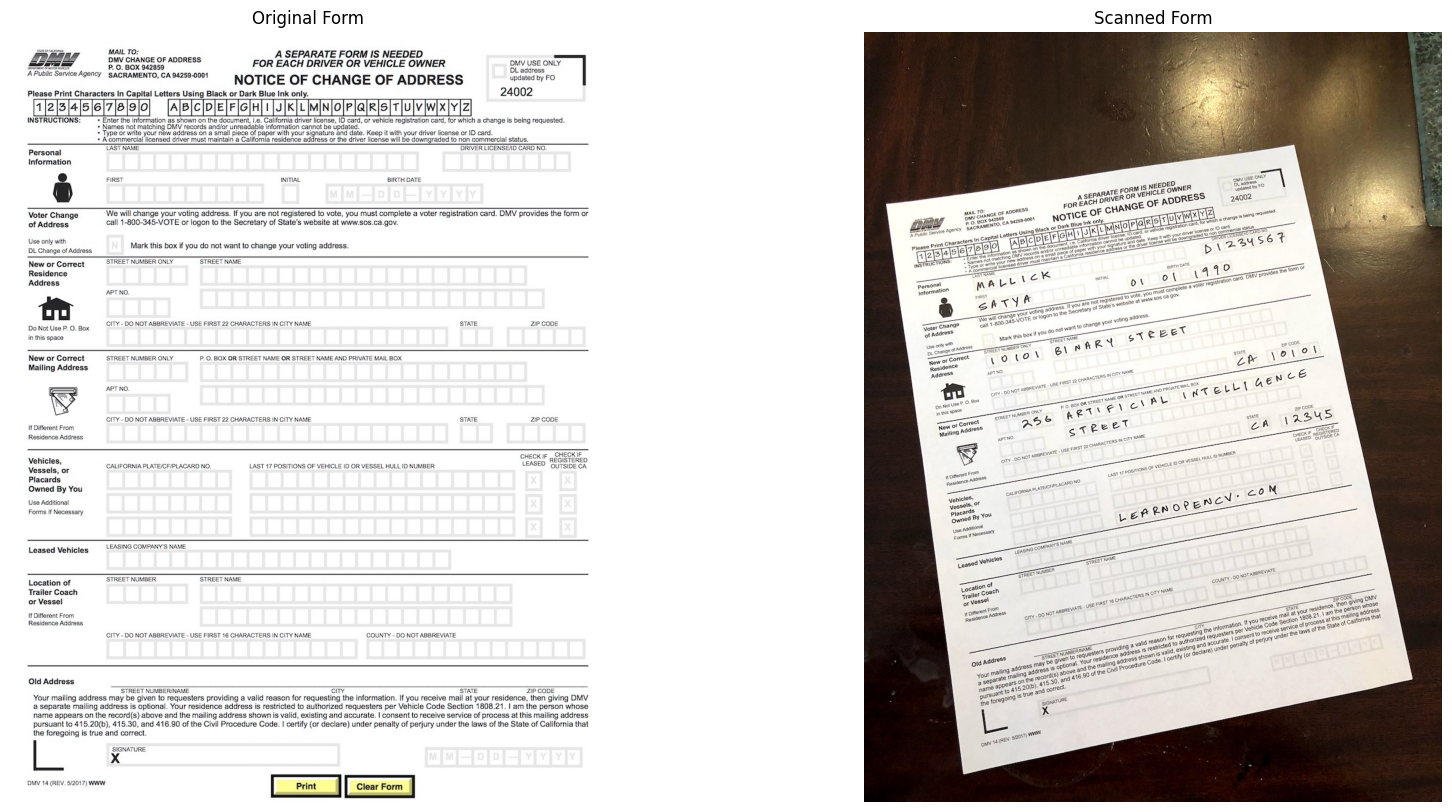

In [12]:
# Display Images

plt.figure(figsize=[20, 10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(img_ref_bgr); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(img_rgb); plt.title("Scanned Form")

#### Step 2: Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations

#### Feature matching using **ORB** algorithm

**ORB** is a fusion of **FAST keypoint detector** and BRIEF descriptor with some added features to improve the performance. FAST is Features from Accelerated Segment Test used to detect features from the provided image. It also uses a pyramid to produce multiscale-features. Now it doesn’t compute the orientation and descriptors for the features, so this is where BRIEF comes in the role.

#### ORB Workflow (Under the Hood):

1. Keypoint Detection — FAST:

- FAST = Features from Accelerated Segment Test
- Looks for corners in the image by comparing pixel brightness around a circle.
- It's very fast but not rotation-invariant by itself.

2. Orientation Assignment:

- ORB adds orientation to each keypoint by computing the intensity centroid, making it rotation-invariant.

3. Descriptor Extraction — BRIEF:

- BRIEF = Binary Robust Independent Elementary Features

- Describes the patch around a keypoint as a binary string.

- ORB rotates BRIEF according to the keypoint orientation → Rotated BRIEF.

4. Feature Matching (done later):

- Compares descriptors using Hamming distance (because descriptors are binary).

- Matches are used for tasks like image alignment, object detection, or structure from motion.


In [ ]:
img_ref_gry = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
img_gry = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints_ref, descriptors_ref = orb.detectAndCompute(img_ref_gry, None)
keypoints_img, descriptors_img = orb.detectAndCompute(img_gry, None)

# KeyPoint:	A distinctive point in the image (like a corner).
# Descriptor: A compact vector (binary in ORB) representing the keypoint’s neighborhood.